In [8]:
"""
================================================================================
CYBERSECURITY THREAT DETECTION SYSTEM - COMPLETE IMPLEMENTATION
================================================================================

BUSINESS OBJECTIVES:
1. Detect malicious network activities in real-time from system logs
2. Reduce false positives while maintaining high threat detection rates
3. Prioritize threats by risk level for security team response
4. Identify attack patterns and suspicious behaviors
5. Provide actionable insights for security policy improvements

BUSINESS QUESTIONS TO ANSWER:
1. What percentage of network traffic is potentially malicious?
2. Which IP addresses are most frequently involved in suspicious activities?
3. What are the most common attack vectors (protocols, paths)?
4. During which time periods do most attacks occur?
5. What is the detection accuracy of our models?
6. Which features best distinguish malicious from benign traffic?

ALGORITHMS USED:
1. Isolation Forest - Unsupervised anomaly detection using random forests
2. Autoencoder (Deep Learning) - Neural network for reconstruction-based detection
3. DBSCAN - Density-based clustering for outlier detection
4. Ensemble Method - Voting mechanism combining all models
5. PCA - Dimensionality reduction for visualization

METHODOLOGY:
- Unsupervised Learning (no labels needed for training)
- Feature Engineering from raw logs
- Multi-model ensemble approach
- Risk scoring system
- Real-time prediction capability
================================================================================
"""

# ============================================================================
# PART 1: IMPORTS AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Models
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# Metrics
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_score, recall_score, f1_score)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("="*80)
print("CYBERSECURITY THREAT DETECTION SYSTEM")
print("="*80)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# ============================================================================
# PART 2: DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

print("\n[STEP 1] Loading Dataset...")
df = pd.read_csv('cybersecurity_threat_detection_logs.csv')

print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumn Names: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nFirst 5 rows:\n{df.head()}")

# Basic Statistics
print(f"\n{df.describe()}")

# Threat Distribution
print(f"\nThreat Label Distribution:")
print(df['threat_label'].value_counts())
print(f"Malicious Rate: {(df['threat_label']=='malicious').sum()/len(df)*100:.2f}%")

# ============================================================================
# PART 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n[STEP 2] Exploratory Data Analysis...")

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract temporal features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print("✓ Temporal features extracted")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Hourly Activity
df['hour'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Log Activity by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Count')

# Plot 2: Threat Distribution
df['threat_label'].value_counts().plot(kind='bar', ax=axes[0,1],
                                       color=['green', 'red', 'orange'])
axes[0,1].set_title('Threat Label Distribution')
axes[0,1].set_ylabel('Count')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=0)

# Plot 3: Protocol Distribution
df['protocol'].value_counts().plot(kind='bar', ax=axes[1,0], color='coral')
axes[1,0].set_title('Protocol Distribution')
axes[1,0].set_xlabel('Protocol')
axes[1,0].set_ylabel('Count')

# Plot 4: Action Distribution
df['action'].value_counts().plot(kind='bar', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Action Distribution (Allowed vs Blocked)')
axes[1,1].set_xlabel('Action')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
print("✓ EDA plots saved to 'eda_overview.png'")
plt.show()

# Bytes transferred analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df.boxplot(column='bytes_transferred', by='threat_label')
plt.title('Bytes Transferred by Threat Label')
plt.suptitle('')
plt.ylabel('Bytes')

plt.subplot(1, 2, 2)
df['bytes_transferred'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Bytes Transferred')
plt.xlabel('Bytes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('bytes_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Bytes analysis saved to 'bytes_analysis.png'")
plt.show()

# ============================================================================
# PART 4: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 3] Feature Engineering...")

# IP Address Features
df['source_ip'] = df['source_ip'].fillna("0.0.0.0")
df['dest_ip'] = df['dest_ip'].fillna("0.0.0.0")

# Split IP addresses into octets safely
src_split = df['source_ip'].str.split('.', expand=True)
dst_split = df['dest_ip'].str.split('.', expand=True)

# Some IPs might be malformed (e.g., '192.168.0'), fill missing parts with 0
src_split = src_split.fillna(0)
dst_split = dst_split.fillna(0)

# Convert to integers
src_split = src_split.astype(int)
dst_split = dst_split.astype(int)

# Create subnet and IP distance features
df['same_subnet'] = (
    (df['src_oct1'] == df['dst_oct1']) &
    (df['src_oct2'] == df['dst_oct2'])
).astype(int)

df['ip_distance'] = (
    abs(df['src_oct1'] - df['dst_oct1']) * 256**3 +
    abs(df['src_oct2'] - df['dst_oct2']) * 256**2 +
    abs(df['src_oct3'] - df['dst_oct3']) * 256 +
    abs(df['src_oct4'] - df['dst_oct4'])
)
print("✓ same_subnet and ip_distance features created")

# Assign back to dataframe with proper column names
import numpy as np

def safe_split_ip(ip):
    try:
        parts = ip.split('.')
        if len(parts) != 4:
            return [0, 0, 0, 0]
        return [int(p) if p.isdigit() else 0 for p in parts]
    except Exception:
        return [0, 0, 0, 0]

df[['src_oct1', 'src_oct2', 'src_oct3', 'src_oct4']] = df['source_ip'].fillna('0.0.0.0').apply(safe_split_ip).tolist()
df[['dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4']] = df['dest_ip'].fillna('0.0.0.0').apply(safe_split_ip).tolist()

print("✓ Robust IP octet features created successfully")

df['is_external_source'] = ~df['source_ip'].str.startswith('192.168')
df['is_external_dest'] = ~df['dest_ip'].str.startswith('192.168')

print("✓ IP features created")

# Aggregated Features per Source IP
source_stats = df.groupby('source_ip').agg({
    'bytes_transferred': ['mean', 'std', 'max', 'min'],
    'protocol': 'count',
    'action': lambda x: (x == 'blocked').sum()
}).reset_index()

source_stats.columns = ['source_ip', 'src_bytes_mean', 'src_bytes_std',
                        'src_bytes_max', 'src_bytes_min',
                        'src_request_count', 'src_blocked_count']

df = df.merge(source_stats, on='source_ip', how='left')

# Aggregated Features per Destination IP
dest_stats = df.groupby('dest_ip').agg({
    'bytes_transferred': ['mean', 'std'],
    'protocol': 'count'
}).reset_index()

dest_stats.columns = ['dest_ip', 'dst_bytes_mean', 'dst_bytes_std',
                     'dst_request_count']

df = df.merge(dest_stats, on='dest_ip', how='left')

# Fill NaN in std (happens with single observation)
df['src_bytes_std'].fillna(0, inplace=True)
df['dst_bytes_std'].fillna(0, inplace=True)

print("✓ Aggregated features created")

# User Agent Features
df['ua_length'] = df['user_agent'].str.len()
df['is_browser'] = df['user_agent'].str.contains(
    'Mozilla|Chrome|Safari', case=False, na=False).astype(int)
df['is_scanner'] = df['user_agent'].str.contains(
    'Nmap|sqlmap|curl', case=False, na=False).astype(int)
df['ua_mozilla'] = df['user_agent'].str.contains(
    'Mozilla', case=False, na=False).astype(int)
df['ua_nmap'] = df['user_agent'].str.contains(
    'Nmap', case=False, na=False).astype(int)
df['ua_sqlmap'] = df['user_agent'].str.contains(
    'SQLMap', case=False, na=False).astype(int)
df['ua_curl'] = df['user_agent'].str.contains(
    'curl', case=False, na=False).astype(int)

print("✓ User Agent features created")

# Request Path Features
df['path_length'] = df['request_path'].str.len()
df['is_admin_path'] = df['request_path'].str.contains(
    'admin|config', case=False, na=False).astype(int)
df['is_sensitive_path'] = df['request_path'].str.contains(
    'backup|secure|home|root', case=False, na=False).astype(int)
df['has_sql_injection'] = df['request_path'].str.contains(
    'DROP|SELECT|UNION|passwd', case=False, na=False).astype(int)

print("✓ Request path features created")

# Encode Categorical Variables
le_dict = {}
categorical_features = ['protocol', 'action', 'log_type']

for col in categorical_features:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    le_dict[col] = le

print("✓ Categorical encoding completed")

print(f"\nTotal Features Created: {len(df.columns)}")

# ============================================================================
# PART 5: DATA PREPROCESSING FOR MODELING
# ============================================================================

print("\n[STEP 4] Data Preprocessing...")

# Select features for modeling
feature_cols = [
    # Temporal
    'hour', 'day', 'month', 'day_of_week', 'is_weekend',
    # Encoded categorical
    'protocol_encoded', 'action_encoded', 'log_type_encoded',
    # Numerical
    'bytes_transferred',
    # IP features
    'src_oct1', 'src_oct2', 'src_oct3', 'src_oct4',
    'dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4',
    'same_subnet', 'ip_distance',
    'is_external_source', 'is_external_dest',
    # Aggregated
    'src_bytes_mean', 'src_bytes_std', 'src_bytes_max', 'src_bytes_min',
    'src_request_count', 'src_blocked_count',
    'dst_bytes_mean', 'dst_bytes_std', 'dst_request_count',
    # User agent
    'ua_length', 'is_browser', 'is_scanner',
    'ua_mozilla', 'ua_nmap', 'ua_sqlmap', 'ua_curl',
    # Path
    'path_length', 'is_admin_path', 'is_sensitive_path', 'has_sql_injection'
]

# Create feature matrix
X = df[feature_cols].copy()
y = (df['threat_label'] != 'benign').astype(int)  # Binary: 0=benign, 1=threat

print(f"✓ Feature matrix created: {X.shape}")
print(f"✓ Features selected: {len(feature_cols)}")

# Handle missing values
X.fillna(X.median(), inplace=True)
print(f"✓ Missing values filled")

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print(f"✓ Features scaled (StandardScaler)")
print(f"\nScaled feature statistics:")
print(f"Mean: {X_scaled.mean():.6f}")
print(f"Std: {X_scaled.std():.6f}")

# ============================================================================
# PART 6: MODEL 1 - ISOLATION FOREST
# ============================================================================

print("\n[STEP 5] Training Isolation Forest...")

# Set contamination rate based on actual threat rate
contamination_rate = y.sum() / len(y)
print(f"Contamination rate: {contamination_rate:.4f}")

# Initialize and train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination_rate,
    max_samples='auto',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

iso_forest.fit(X_scaled)
print("✓ Isolation Forest trained")

# Predictions
df['iso_prediction'] = iso_forest.predict(X_scaled)
df['iso_anomaly_score'] = iso_forest.score_samples(X_scaled)
df['iso_is_anomaly'] = (df['iso_prediction'] == -1).astype(int)

print(f"\nIsolation Forest Results:")
print(f"Anomalies detected: {df['iso_is_anomaly'].sum()}")
print(f"Detection rate: {df['iso_is_anomaly'].sum()/len(df)*100:.2f}%")

# Evaluation
print("\n" + "="*80)
print("ISOLATION FOREST EVALUATION")
print("="*80)

cm = confusion_matrix(y, df['iso_is_anomaly'])
print(f"\nConfusion Matrix:")
print(cm)

print(f"\nClassification Report:")
print(classification_report(y, df['iso_is_anomaly'],
                          target_names=['Benign', 'Threat']))

roc_auc_iso = roc_auc_score(y, -df['iso_anomaly_score'])
print(f"ROC-AUC Score: {roc_auc_iso:.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Benign', 'Pred Threat'],
            yticklabels=['True Benign', 'True Threat'])
axes[0].set_title('Isolation Forest - Confusion Matrix')

# Score Distribution
axes[1].hist(df[y==0]['iso_anomaly_score'], bins=50, alpha=0.6,
            label='Benign', color='green')
axes[1].hist(df[y==1]['iso_anomaly_score'], bins=50, alpha=0.6,
            label='Threat', color='red')
axes[1].set_xlabel('Anomaly Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Anomaly Score Distribution')
axes[1].legend()

# ROC Curve
fpr, tpr, _ = roc_curve(y, -df['iso_anomaly_score'])
axes[2].plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc_iso:.3f}')
axes[2].plot([0, 1], [0, 1], 'k--', label='Random')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve - Isolation Forest')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('isolation_forest_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Results saved to 'isolation_forest_results.png'")
plt.show()

# ============================================================================
# PART 7: MODEL 2 - AUTOENCODER (DEEP LEARNING)
# ============================================================================

print("\n[STEP 6] Building and Training Autoencoder...")

# Architecture
input_dim = X_scaled.shape[1]
encoding_dim = 14

# Build model
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(24, activation='relu')(input_layer)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(24, activation='relu')(encoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(autoencoder.summary())

# Train only on benign data
X_train_normal = X_scaled[y == 0]
print(f"\n✓ Training on {len(X_train_normal)} benign samples...")

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    shuffle=True
)

print("✓ Autoencoder trained")

# Calculate reconstruction error
X_reconstructed = autoencoder.predict(X_scaled, verbose=0)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)
df['ae_reconstruction_error'] = reconstruction_error

# Set threshold (95th percentile of benign data)
threshold = np.percentile(reconstruction_error[y == 0], 95)
print(f"✓ Reconstruction error threshold: {threshold:.6f}")

df['ae_is_anomaly'] = (df['ae_reconstruction_error'] > threshold).astype(int)

print(f"\nAutoencoder Results:")
print(f"Anomalies detected: {df['ae_is_anomaly'].sum()}")

# Evaluation
print("\n" + "="*80)
print("AUTOENCODER EVALUATION")
print("="*80)

cm_ae = confusion_matrix(y, df['ae_is_anomaly'])
print(f"\nConfusion Matrix:")
print(cm_ae)

print(f"\nClassification Report:")
print(classification_report(y, df['ae_is_anomaly'],
                          target_names=['Benign', 'Threat']))

roc_auc_ae = roc_auc_score(y, df['ae_reconstruction_error'])
print(f"ROC-AUC Score: {roc_auc_ae:.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training history
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Autoencoder Training')
axes[0].legend()
axes[0].grid(True)

# Error distribution
axes[1].hist(df[y==0]['ae_reconstruction_error'], bins=50, alpha=0.6,
            label='Benign', color='green')
axes[1].hist(df[y==1]['ae_reconstruction_error'], bins=50, alpha=0.6,
            label='Threat', color='red')
axes[1].axvline(threshold, color='black', linestyle='--', label='Threshold')
axes[1].set_xlabel('Reconstruction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Reconstruction Error Distribution')
axes[1].legend()

# ROC Curve
fpr_ae, tpr_ae, _ = roc_curve(y, df['ae_reconstruction_error'])
axes[2].plot(fpr_ae, tpr_ae, linewidth=2, label=f'AUC = {roc_auc_ae:.3f}')
axes[2].plot([0, 1], [0, 1], 'k--', label='Random')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve - Autoencoder')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('autoencoder_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Results saved to 'autoencoder_results.png'")
plt.show()

# ============================================================================
# PART 8: MODEL 3 - DBSCAN CLUSTERING
# ============================================================================

print("\n[STEP 7] Applying DBSCAN Clustering...")

dbscan = DBSCAN(eps=3, min_samples=10, n_jobs=-1)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)
df['dbscan_is_anomaly'] = (df['dbscan_cluster'] == -1).astype(int)

print(f"✓ DBSCAN completed")
print(f"Number of clusters: {df['dbscan_cluster'].nunique() - 1}")
print(f"Outliers detected: {df['dbscan_is_anomaly'].sum()}")

print(f"\nClassification Report:")
print(classification_report(y, df['dbscan_is_anomaly'],
                          target_names=['Benign', 'Threat']))

# ============================================================================
# PART 9: ENSEMBLE METHOD
# ============================================================================

print("\n[STEP 8] Creating Ensemble Model...")

# Voting: Anomaly if ANY model detects it
df['ensemble_anomaly'] = ((df['iso_is_anomaly'] == 1) |
                          (df['ae_is_anomaly'] == 1) |
                          (df['dbscan_is_anomaly'] == 1)).astype(int)

# Risk Scoring
df['risk_score'] = (
    df['iso_is_anomaly'] * 35 +
    df['ae_is_anomaly'] * 35 +
    df['dbscan_is_anomaly'] * 20 +
    df['is_scanner'] * 5 +
    df['is_admin_path'] * 5
)

print(f"✓ Ensemble created")
print(f"Total anomalies: {df['ensemble_anomaly'].sum()}")

# Evaluation
print("\n" + "="*80)
print("ENSEMBLE MODEL EVALUATION")
print("="*80)

cm_ensemble = confusion_matrix(y, df['ensemble_anomaly'])
print(f"\nConfusion Matrix:")
print(cm_ensemble)

print(f"\nClassification Report:")
print(classification_report(y, df['ensemble_anomaly'],
                          target_names=['Benign', 'Threat']))

# Model Comparison
comparison = pd.DataFrame({
    'Model': ['Isolation Forest', 'Autoencoder', 'DBSCAN', 'Ensemble'],
    'Accuracy': [
        accuracy_score(y, df['iso_is_anomaly']),
        accuracy_score(y, df['ae_is_anomaly']),
        accuracy_score(y, df['dbscan_is_anomaly']),
        accuracy_score(y, df['ensemble_anomaly'])
    ],
    'Precision': [
        precision_score(y, df['iso_is_anomaly']),
        precision_score(y, df['ae_is_anomaly']),
        precision_score(y, df['dbscan_is_anomaly']),
        precision_score(y, df['ensemble_anomaly'])
    ],
    'Recall': [
        recall_score(y, df['iso_is_anomaly']),
        recall_score(y, df['ae_is_anomaly']),
        recall_score(y, df['dbscan_is_anomaly']),
        recall_score(y, df['ensemble_anomaly'])
    ],
    'F1-Score': [
        f1_score(y, df['iso_is_anomaly']),
        f1_score(y, df['ae_is_anomaly']),
        f1_score(y, df['dbscan_is_anomaly']),
        f1_score(y, df['ensemble_anomaly'])
    ],
    'ROC-AUC': [roc_auc_iso, roc_auc_ae, '-', '-']
})

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison.to_string(index=False))

# Save comparison
comparison.to_csv('model_comparison.csv', index=False)
print("\n✓ Comparison saved to 'model_comparison.csv'")

# ============================================================================
# PART 10: BUSINESS INSIGHTS & ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("BUSINESS INSIGHTS & ANSWERS TO KEY QUESTIONS")
print("="*80)

anomalies = df[df['ensemble_anomaly'] == 1]

print(f"\n1. THREAT DETECTION SUMMARY")
print(f"   • Total logs analyzed: {len(df):,}")
print(f"   • Threats detected: {len(anomalies):,} ({len(anomalies)/len(df)*100:.2f}%)")
print(f"   • True threats in data: {y.sum():,}")
print(f"   • Detection rate: {((df['ensemble_anomaly']==1) & (y==1)).sum()/y.sum()*100:.1f}%")

print(f"\n2. TOP SUSPICIOUS IP ADDRESSES")
top_source_ips = anomalies['source_ip'].value_counts().head(5)
for ip, count in top_source_ips.items():
    print(f"   • {ip}: {count} suspicious activities")

print(f"\n3. MOST COMMON ATTACK VECTORS")
print(f"   • Protocols: {anomalies['protocol'].value_counts().head(3).to_dict()}")
print(f"   • Paths: {anomalies[anomalies['is_admin_path']==1].shape[0]} admin paths targeted")
print(f"   • Scanner tools: {anomalies['is_scanner'].sum()} detected")

print(f"\n4. TEMPORAL PATTERNS")
hourly_threats = anomalies.groupby('hour').size().sort_values(ascending=False)
print(f"   • Peak threat hour: {hourly_threats.index[0]}:00 ({hourly_threats.values[0]} threats)")
print(f"   • Weekend threats: {anomalies['is_weekend'].sum()}")
print(f"   • Weekday threats: {len(anomalies) - anomalies['is_weekend'].sum()}")

print(f"\n5. RISK DISTRIBUTION")
high_risk = anomalies[anomalies['risk_score'] >= 75]
medium_risk = anomalies[(anomalies['risk_score'] >= 50) & (anomalies['risk_score'] < 75)]
low_risk = anomalies[anomalies['risk_score'] < 50]
print(f"   • High risk (≥75): {len(high_risk)} ({len(high_risk)/len(anomalies)*100:.1f}%)")
print(f"   • Medium risk (50-74): {len(medium_risk)} ({len(medium_risk)/len(anomalies)*100:.1f}%)")
print(f"   • Low risk (<50): {len(low_risk)} ({len(low_risk)/len(anomalies)*100:.1f}%)")

print(f"\n6. MODEL PERFORMANCE")
print(f"   • Best F1-Score: {comparison['F1-Score'].max():.3f} ({comparison.loc[comparison['F1-Score'].idxmax(), 'Model']})")
print(f"   • Best Precision: {comparison['Precision'].max():.3f} ({comparison.loc[comparison['Precision'].idxmax(), 'Model']})")
print(f"   • Best Recall: {comparison['Recall'].max():.3f} ({comparison.loc[comparison['Recall'].idxmax(), 'Model']})")

# ============================================================================
# PART 11: SAVE RESULTS
# ============================================================================

print("\n[STEP 9] Saving Results...")

# Full results
output_cols = ['timestamp', 'source_ip', 'dest_ip', 'protocol', 'action',
               'threat_label', 'iso_is_anomaly', 'ae_is_anomaly',
               'dbscan_is_anomaly', 'ensemble_anomaly', 'risk_score']
df[output_cols].to_csv('threat_detection_results.csv', index=False)
print("✓ Full results saved to 'threat_detection_results.csv'")

# Anomalies only
anomalies[output_cols].to_csv('detected_anomalies.csv', index=False)
print(f"✓ Detected anomalies saved to 'detected_anomalies.csv' ({len(anomalies)} records)")


CYBERSECURITY THREAT DETECTION SYSTEM
TensorFlow Version: 2.19.0
Execution Time: 2025-10-27 16:22:13

[STEP 1] Loading Dataset...


ParserError: Error tokenizing data. C error: EOF inside string starting at row 453591

CYBERSECURITY THREAT DETECTION SYSTEM
TensorFlow Version: 2.19.0
Execution Time: 2025-10-27 16:27:04

[STEP 1] Loading Dataset...
✓ Dataset loaded: 626299 rows, 10 columns

Column Names: ['timestamp', 'source_ip', 'dest_ip', 'protocol', 'action', 'threat_label', 'log_type', 'bytes_transferred', 'user_agent', 'request_path']

Data Types:
timestamp            object
source_ip            object
dest_ip              object
protocol             object
action               object
threat_label         object
log_type             object
bytes_transferred     int64
user_agent           object
request_path         object
dtype: object

Missing Values:
timestamp            0
source_ip            0
dest_ip              0
protocol             0
action               0
threat_label         0
log_type             0
bytes_transferred    0
user_agent           1
request_path         1
dtype: int64

First 5 rows:
             timestamp      source_ip        dest_ip protocol   action  \
0  2024-05-01T00:0

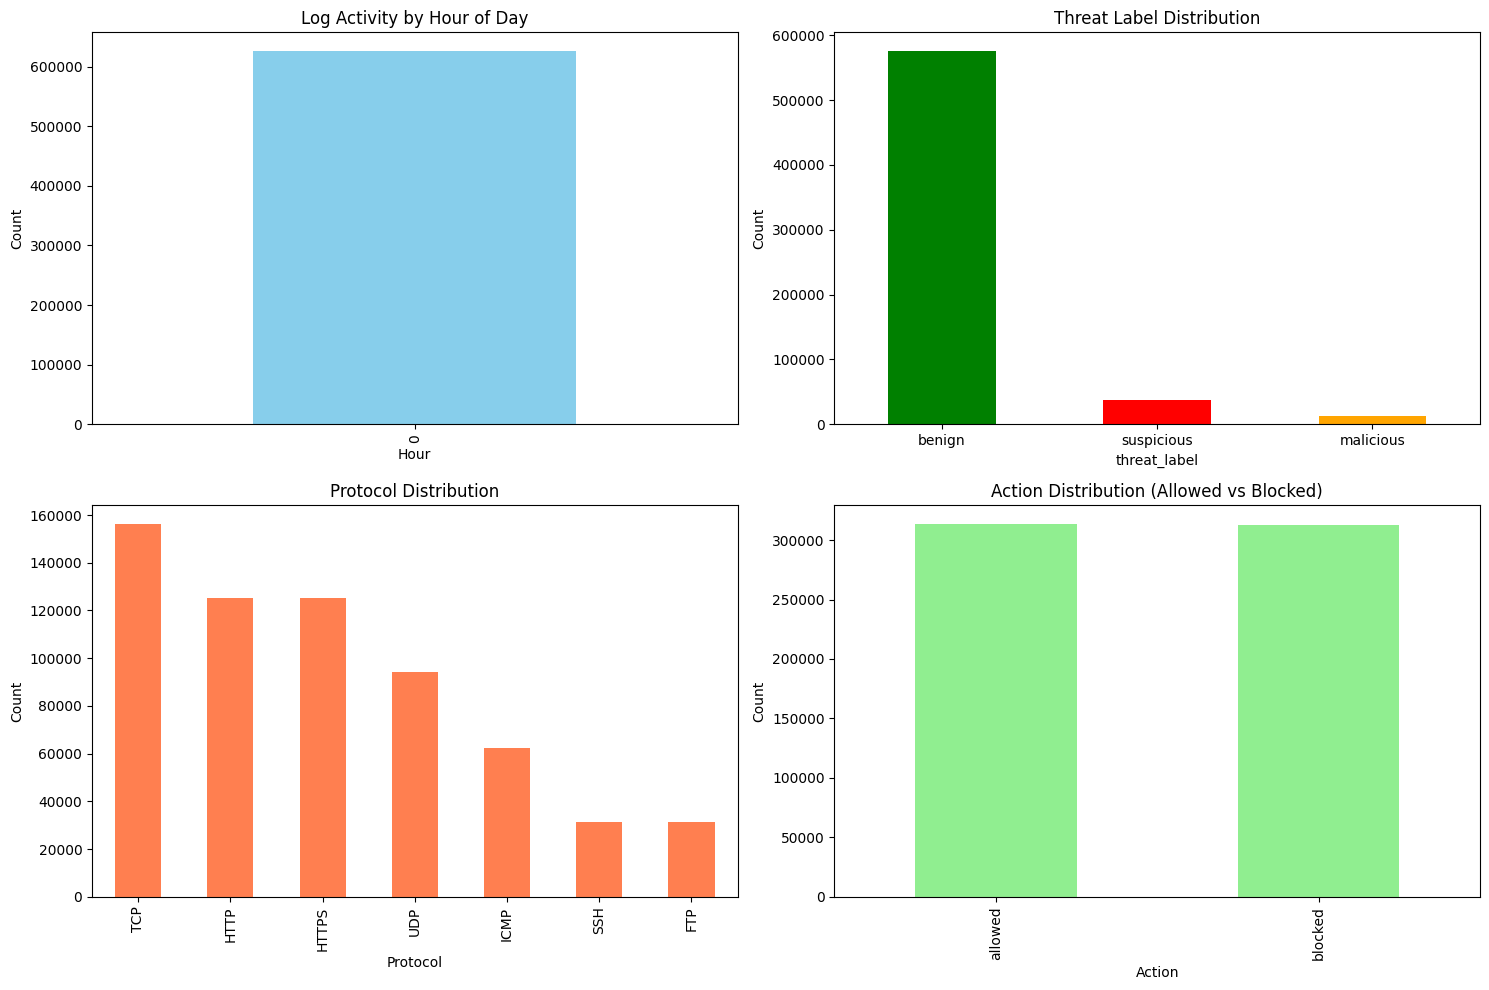

✓ Bytes analysis saved to 'bytes_analysis.png'


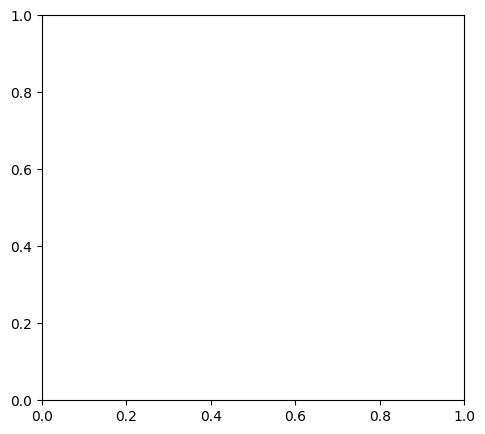

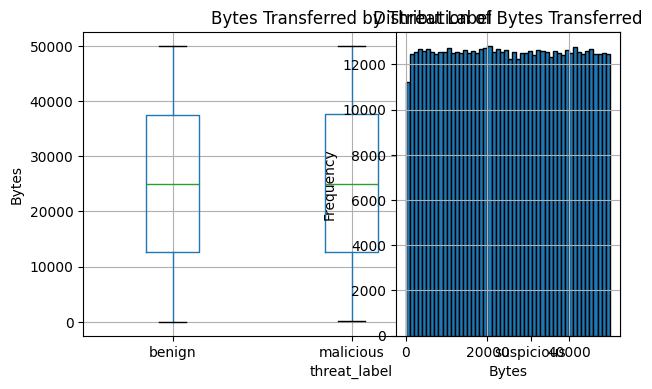


[STEP 3] Feature Engineering...
✓ Robust IP octet features created successfully
✓ IP features created
✓ Aggregated features created
✓ User Agent features created
✓ Request path features created
✓ Categorical encoding completed

Total Features Created: 50

[STEP 4] Data Preprocessing...
✓ Feature matrix created: (626299, 41)
✓ Features selected: 41
✓ Missing values filled
✓ Features scaled (StandardScaler)

Scaled feature statistics:
Mean: -0.000000
Std: 0.937043

[STEP 5] Training Isolation Forest...
Contamination rate: 0.0807
✓ Isolation Forest trained

Isolation Forest Results:
Anomalies detected: 50515
Detection rate: 8.07%

ISOLATION FOREST EVALUATION

Confusion Matrix:
[[546009  29775]
 [ 29775  20740]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.95      0.95    575784
      Threat       0.41      0.41      0.41     50515

    accuracy                           0.90    626299
   macro avg       0.68      0.68      

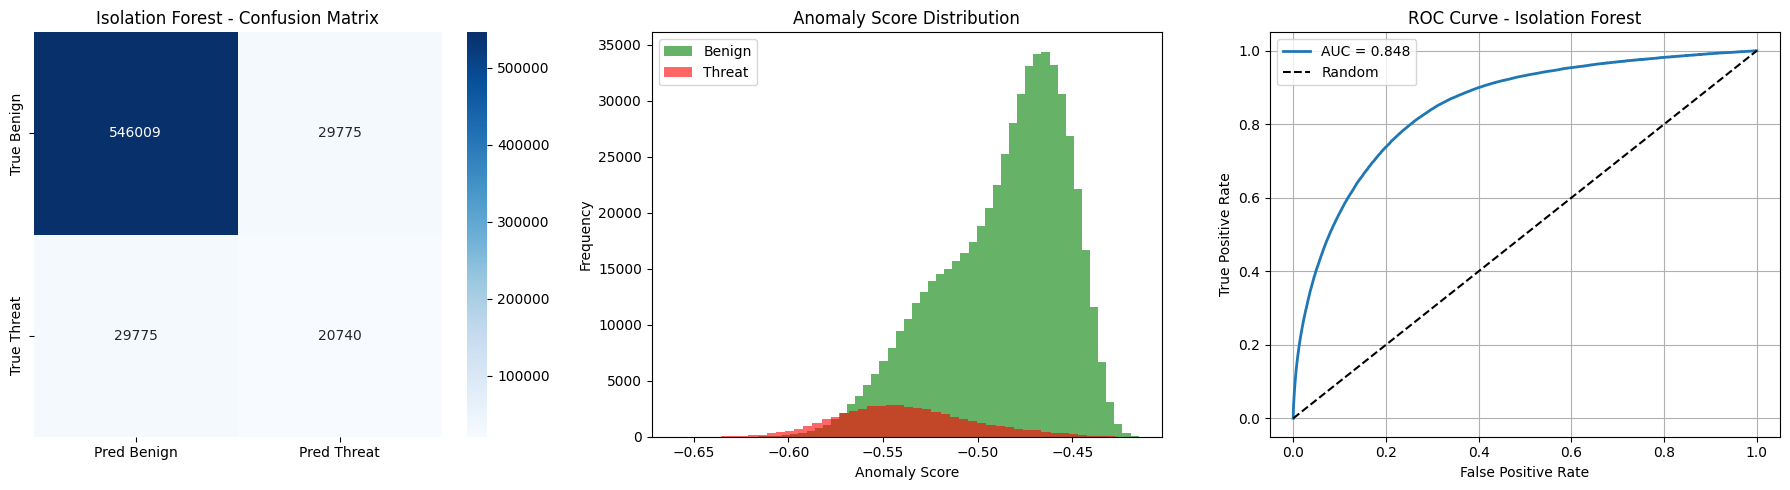


[STEP 6] Building and Training Autoencoder...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 41)             │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,743 (10.71 KB)

 Trainable params: 2,743 (10.71 KB)

 Non-trainable params: 0 (0.00 B)

None

✓ Training on 575784 benign samples...
✓ Autoencoder trained
✓ Reconstruction error threshold: 0.476053

Autoencoder Results:
Anomalies detected: 52545

AUTOENCODER EVALUATION

Confusion Matrix:
[[546994  28790]
 [ 26760  23755]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.95      0.95    575784
      Threat       0.45      0.47      0.46     50515

    accuracy                           0.91    626299
   macro avg       0.70      0.71      0.71    626299
weighted avg       0.91      0.91      0.91    626299

ROC-AUC Score: 0.8227

✓ Results saved to 'autoencoder_results.png'


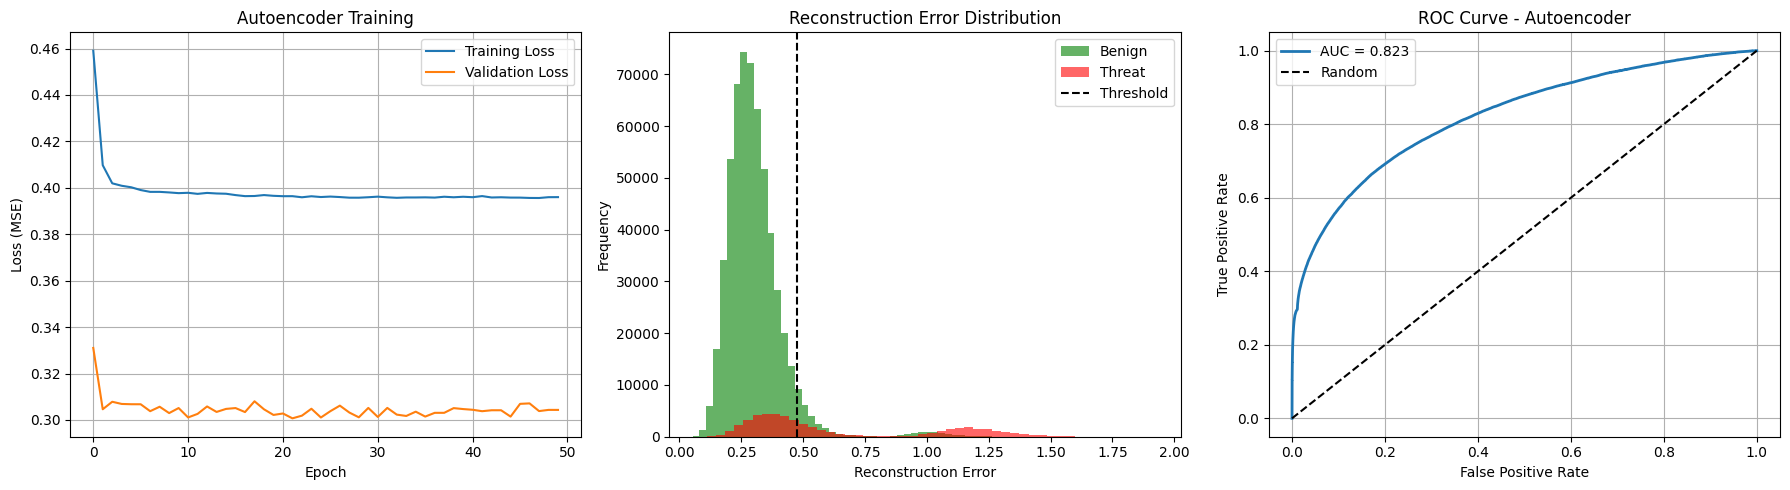


[STEP 7] Applying DBSCAN Clustering...
✓ DBSCAN completed
Number of clusters: 278
Outliers detected: 103783

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.88      0.92    575784
      Threat       0.34      0.70      0.46     50515

    accuracy                           0.87    626299
   macro avg       0.66      0.79      0.69    626299
weighted avg       0.92      0.87      0.89    626299


[STEP 8] Creating Ensemble Model...
✓ Ensemble created
Total anomalies: 126491

ENSEMBLE MODEL EVALUATION

Confusion Matrix:
[[486817  88967]
 [ 12991  37524]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.85      0.91    575784
      Threat       0.30      0.74      0.42     50515

    accuracy                           0.84    626299
   macro avg       0.64      0.79      0.66    626299
weighted avg       0.92      0.84      0.87    626299


MODEL COMPARISON
          

In [9]:
"""
================================================================================
CYBERSECURITY THREAT DETECTION SYSTEM - COMPLETE IMPLEMENTATION
================================================================================

BUSINESS OBJECTIVES:
1. Detect malicious network activities in real-time from system logs
2. Reduce false positives while maintaining high threat detection rates
3. Prioritize threats by risk level for security team response
4. Identify attack patterns and suspicious behaviors
5. Provide actionable insights for security policy improvements

BUSINESS QUESTIONS TO ANSWER:
1. What percentage of network traffic is potentially malicious?
2. Which IP addresses are most frequently involved in suspicious activities?
3. What are the most common attack vectors (protocols, paths)?
4. During which time periods do most attacks occur?
5. What is the detection accuracy of our models?
6. Which features best distinguish malicious from benign traffic?

ALGORITHMS USED:
1. Isolation Forest - Unsupervised anomaly detection using random forests
2. Autoencoder (Deep Learning) - Neural network for reconstruction-based detection
3. DBSCAN - Density-based clustering for outlier detection
4. Ensemble Method - Voting mechanism combining all models
5. PCA - Dimensionality reduction for visualization

METHODOLOGY:
- Unsupervised Learning (no labels needed for training)
- Feature Engineering from raw logs
- Multi-model ensemble approach
- Risk scoring system
- Real-time prediction capability
================================================================================
"""

# ============================================================================
# PART 1: IMPORTS AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Models
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# Metrics
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_score, recall_score, f1_score)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("="*80)
print("CYBERSECURITY THREAT DETECTION SYSTEM")
print("="*80)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# ============================================================================
# PART 2: DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

print("\n[STEP 1] Loading Dataset...")
df = pd.read_csv('cybersecurity_threat_detection_logs.csv')

print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumn Names: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nFirst 5 rows:\n{df.head()}")

# Basic Statistics
print(f"\n{df.describe()}")

# Threat Distribution
print(f"\nThreat Label Distribution:")
print(df['threat_label'].value_counts())
print(f"Malicious Rate: {(df['threat_label']=='malicious').sum()/len(df)*100:.2f}%")

# ============================================================================
# PART 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n[STEP 2] Exploratory Data Analysis...")

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract temporal features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

print("✓ Temporal features extracted")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Hourly Activity
df['hour'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Log Activity by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Count')

# Plot 2: Threat Distribution
df['threat_label'].value_counts().plot(kind='bar', ax=axes[0,1],
                                       color=['green', 'red', 'orange'])
axes[0,1].set_title('Threat Label Distribution')
axes[0,1].set_ylabel('Count')
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=0)

# Plot 3: Protocol Distribution
df['protocol'].value_counts().plot(kind='bar', ax=axes[1,0], color='coral')
axes[1,0].set_title('Protocol Distribution')
axes[1,0].set_xlabel('Protocol')
axes[1,0].set_ylabel('Count')

# Plot 4: Action Distribution
df['action'].value_counts().plot(kind='bar', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Action Distribution (Allowed vs Blocked)')
axes[1,1].set_xlabel('Action')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
print("✓ EDA plots saved to 'eda_overview.png'")
plt.show()

# Bytes transferred analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df.boxplot(column='bytes_transferred', by='threat_label')
plt.title('Bytes Transferred by Threat Label')
plt.suptitle('')
plt.ylabel('Bytes')

plt.subplot(1, 2, 2)
df['bytes_transferred'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Bytes Transferred')
plt.xlabel('Bytes')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('bytes_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Bytes analysis saved to 'bytes_analysis.png'")
plt.show()

# ============================================================================
# PART 4: FEATURE ENGINEERING
# ============================================================================

print("\n[STEP 3] Feature Engineering...")

# IP Address Features
df['source_ip'] = df['source_ip'].fillna("0.0.0.0")
df['dest_ip'] = df['dest_ip'].fillna("0.0.0.0")

# Robust IP octet splitting function
def safe_split_ip(ip):
    try:
        parts = str(ip).split('.')
        if len(parts) != 4:
            return [0, 0, 0, 0]
        return [int(p) if p.isdigit() else 0 for p in parts]
    except Exception:
        return [0, 0, 0, 0]

# Create IP octet features
src_octets = df['source_ip'].apply(safe_split_ip)
dst_octets = df['dest_ip'].apply(safe_split_ip)

df[['src_oct1', 'src_oct2', 'src_oct3', 'src_oct4']] = pd.DataFrame(src_octets.tolist(), index=df.index)
df[['dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4']] = pd.DataFrame(dst_octets.tolist(), index=df.index)

print("✓ Robust IP octet features created successfully")

# Create subnet and IP distance features
df['same_subnet'] = (
    (df['src_oct1'] == df['dst_oct1']) &
    (df['src_oct2'] == df['dst_oct2'])
).astype(int)

df['ip_distance'] = (
    abs(df['src_oct1'] - df['dst_oct1']) * 256**3 +
    abs(df['src_oct2'] - df['dst_oct2']) * 256**2 +
    abs(df['src_oct3'] - df['dst_oct3']) * 256 +
    abs(df['src_oct4'] - df['dst_oct4'])
)

df['is_external_source'] = ~df['source_ip'].str.startswith('192.168')
df['is_external_dest'] = ~df['dest_ip'].str.startswith('192.168')

print("✓ IP features created")

# Aggregated Features per Source IP
source_stats = df.groupby('source_ip').agg({
    'bytes_transferred': ['mean', 'std', 'max', 'min'],
    'protocol': 'count',
    'action': lambda x: (x == 'blocked').sum()
}).reset_index()

source_stats.columns = ['source_ip', 'src_bytes_mean', 'src_bytes_std',
                        'src_bytes_max', 'src_bytes_min',
                        'src_request_count', 'src_blocked_count']

df = df.merge(source_stats, on='source_ip', how='left')

# Aggregated Features per Destination IP
dest_stats = df.groupby('dest_ip').agg({
    'bytes_transferred': ['mean', 'std'],
    'protocol': 'count'
}).reset_index()

dest_stats.columns = ['dest_ip', 'dst_bytes_mean', 'dst_bytes_std',
                     'dst_request_count']

df = df.merge(dest_stats, on='dest_ip', how='left')

# Fill NaN in std (happens with single observation)
df['src_bytes_std'].fillna(0, inplace=True)
df['dst_bytes_std'].fillna(0, inplace=True)

print("✓ Aggregated features created")

# User Agent Features
df['ua_length'] = df['user_agent'].str.len()
df['is_browser'] = df['user_agent'].str.contains(
    'Mozilla|Chrome|Safari', case=False, na=False).astype(int)
df['is_scanner'] = df['user_agent'].str.contains(
    'Nmap|sqlmap|curl', case=False, na=False).astype(int)
df['ua_mozilla'] = df['user_agent'].str.contains(
    'Mozilla', case=False, na=False).astype(int)
df['ua_nmap'] = df['user_agent'].str.contains(
    'Nmap', case=False, na=False).astype(int)
df['ua_sqlmap'] = df['user_agent'].str.contains(
    'SQLMap', case=False, na=False).astype(int)
df['ua_curl'] = df['user_agent'].str.contains(
    'curl', case=False, na=False).astype(int)

print("✓ User Agent features created")

# Request Path Features
df['path_length'] = df['request_path'].str.len()
df['is_admin_path'] = df['request_path'].str.contains(
    'admin|config', case=False, na=False).astype(int)
df['is_sensitive_path'] = df['request_path'].str.contains(
    'backup|secure|home|root', case=False, na=False).astype(int)
df['has_sql_injection'] = df['request_path'].str.contains(
    'DROP|SELECT|UNION|passwd', case=False, na=False).astype(int)

print("✓ Request path features created")

# Encode Categorical Variables
le_dict = {}
categorical_features = ['protocol', 'action', 'log_type']

for col in categorical_features:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    le_dict[col] = le

print("✓ Categorical encoding completed")

print(f"\nTotal Features Created: {len(df.columns)}")

# ============================================================================
# PART 5: DATA PREPROCESSING FOR MODELING
# ============================================================================

print("\n[STEP 4] Data Preprocessing...")

# Select features for modeling
feature_cols = [
    # Temporal
    'hour', 'day', 'month', 'day_of_week', 'is_weekend',
    # Encoded categorical
    'protocol_encoded', 'action_encoded', 'log_type_encoded',
    # Numerical
    'bytes_transferred',
    # IP features
    'src_oct1', 'src_oct2', 'src_oct3', 'src_oct4',
    'dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4',
    'same_subnet', 'ip_distance',
    'is_external_source', 'is_external_dest',
    # Aggregated
    'src_bytes_mean', 'src_bytes_std', 'src_bytes_max', 'src_bytes_min',
    'src_request_count', 'src_blocked_count',
    'dst_bytes_mean', 'dst_bytes_std', 'dst_request_count',
    # User agent
    'ua_length', 'is_browser', 'is_scanner',
    'ua_mozilla', 'ua_nmap', 'ua_sqlmap', 'ua_curl',
    # Path
    'path_length', 'is_admin_path', 'is_sensitive_path', 'has_sql_injection'
]

# Create feature matrix
X = df[feature_cols].copy()
y = (df['threat_label'] != 'benign').astype(int)  # Binary: 0=benign, 1=threat

print(f"✓ Feature matrix created: {X.shape}")
print(f"✓ Features selected: {len(feature_cols)}")

# Handle missing values
X.fillna(X.median(), inplace=True)
print(f"✓ Missing values filled")

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print(f"✓ Features scaled (StandardScaler)")
print(f"\nScaled feature statistics:")
print(f"Mean: {X_scaled.mean():.6f}")
print(f"Std: {X_scaled.std():.6f}")

# ============================================================================
# PART 6: MODEL 1 - ISOLATION FOREST
# ============================================================================

print("\n[STEP 5] Training Isolation Forest...")

# Set contamination rate based on actual threat rate
contamination_rate = y.sum() / len(y)
print(f"Contamination rate: {contamination_rate:.4f}")

# Initialize and train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination_rate,
    max_samples='auto',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

iso_forest.fit(X_scaled)
print("✓ Isolation Forest trained")

# Predictions
df['iso_prediction'] = iso_forest.predict(X_scaled)
df['iso_anomaly_score'] = iso_forest.score_samples(X_scaled)
df['iso_is_anomaly'] = (df['iso_prediction'] == -1).astype(int)

print(f"\nIsolation Forest Results:")
print(f"Anomalies detected: {df['iso_is_anomaly'].sum()}")
print(f"Detection rate: {df['iso_is_anomaly'].sum()/len(df)*100:.2f}%")

# Evaluation
print("\n" + "="*80)
print("ISOLATION FOREST EVALUATION")
print("="*80)

cm = confusion_matrix(y, df['iso_is_anomaly'])
print(f"\nConfusion Matrix:")
print(cm)

print(f"\nClassification Report:")
print(classification_report(y, df['iso_is_anomaly'],
                          target_names=['Benign', 'Threat']))

roc_auc_iso = roc_auc_score(y, -df['iso_anomaly_score'])
print(f"ROC-AUC Score: {roc_auc_iso:.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Benign', 'Pred Threat'],
            yticklabels=['True Benign', 'True Threat'])
axes[0].set_title('Isolation Forest - Confusion Matrix')

# Score Distribution
axes[1].hist(df[y==0]['iso_anomaly_score'], bins=50, alpha=0.6,
            label='Benign', color='green')
axes[1].hist(df[y==1]['iso_anomaly_score'], bins=50, alpha=0.6,
            label='Threat', color='red')
axes[1].set_xlabel('Anomaly Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Anomaly Score Distribution')
axes[1].legend()

# ROC Curve
fpr, tpr, _ = roc_curve(y, -df['iso_anomaly_score'])
axes[2].plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc_iso:.3f}')
axes[2].plot([0, 1], [0, 1], 'k--', label='Random')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve - Isolation Forest')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('isolation_forest_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Results saved to 'isolation_forest_results.png'")
plt.show()

# ============================================================================
# PART 7: MODEL 2 - AUTOENCODER (DEEP LEARNING)
# ============================================================================

print("\n[STEP 6] Building and Training Autoencoder...")

# Architecture
input_dim = X_scaled.shape[1]
encoding_dim = 14

# Build model
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(24, activation='relu')(input_layer)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(24, activation='relu')(encoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(autoencoder.summary())

# Train only on benign data
X_train_normal = X_scaled[y == 0]
print(f"\n✓ Training on {len(X_train_normal)} benign samples...")

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    shuffle=True
)

print("✓ Autoencoder trained")

# Calculate reconstruction error
X_reconstructed = autoencoder.predict(X_scaled, verbose=0)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)
df['ae_reconstruction_error'] = reconstruction_error

# Set threshold (95th percentile of benign data)
threshold = np.percentile(reconstruction_error[y == 0], 95)
print(f"✓ Reconstruction error threshold: {threshold:.6f}")

df['ae_is_anomaly'] = (df['ae_reconstruction_error'] > threshold).astype(int)

print(f"\nAutoencoder Results:")
print(f"Anomalies detected: {df['ae_is_anomaly'].sum()}")

# Evaluation
print("\n" + "="*80)
print("AUTOENCODER EVALUATION")
print("="*80)

cm_ae = confusion_matrix(y, df['ae_is_anomaly'])
print(f"\nConfusion Matrix:")
print(cm_ae)

print(f"\nClassification Report:")
print(classification_report(y, df['ae_is_anomaly'],
                          target_names=['Benign', 'Threat']))

roc_auc_ae = roc_auc_score(y, df['ae_reconstruction_error'])
print(f"ROC-AUC Score: {roc_auc_ae:.4f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training history
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Autoencoder Training')
axes[0].legend()
axes[0].grid(True)

# Error distribution
axes[1].hist(df[y==0]['ae_reconstruction_error'], bins=50, alpha=0.6,
            label='Benign', color='green')
axes[1].hist(df[y==1]['ae_reconstruction_error'], bins=50, alpha=0.6,
            label='Threat', color='red')
axes[1].axvline(threshold, color='black', linestyle='--', label='Threshold')
axes[1].set_xlabel('Reconstruction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Reconstruction Error Distribution')
axes[1].legend()

# ROC Curve
fpr_ae, tpr_ae, _ = roc_curve(y, df['ae_reconstruction_error'])
axes[2].plot(fpr_ae, tpr_ae, linewidth=2, label=f'AUC = {roc_auc_ae:.3f}')
axes[2].plot([0, 1], [0, 1], 'k--', label='Random')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve - Autoencoder')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('autoencoder_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Results saved to 'autoencoder_results.png'")
plt.show()

# ============================================================================
# PART 8: MODEL 3 - DBSCAN CLUSTERING
# ============================================================================

print("\n[STEP 7] Applying DBSCAN Clustering...")

dbscan = DBSCAN(eps=3, min_samples=10, n_jobs=-1)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)
df['dbscan_is_anomaly'] = (df['dbscan_cluster'] == -1).astype(int)

print(f"✓ DBSCAN completed")
print(f"Number of clusters: {df['dbscan_cluster'].nunique() - 1}")
print(f"Outliers detected: {df['dbscan_is_anomaly'].sum()}")

print(f"\nClassification Report:")
print(classification_report(y, df['dbscan_is_anomaly'],
                          target_names=['Benign', 'Threat']))

# ============================================================================
# PART 9: ENSEMBLE METHOD
# ============================================================================

print("\n[STEP 8] Creating Ensemble Model...")

# Voting: Anomaly if ANY model detects it
df['ensemble_anomaly'] = ((df['iso_is_anomaly'] == 1) |
                          (df['ae_is_anomaly'] == 1) |
                          (df['dbscan_is_anomaly'] == 1)).astype(int)

# Risk Scoring
df['risk_score'] = (
    df['iso_is_anomaly'] * 35 +
    df['ae_is_anomaly'] * 35 +
    df['dbscan_is_anomaly'] * 20 +
    df['is_scanner'] * 5 +
    df['is_admin_path'] * 5
)

print(f"✓ Ensemble created")
print(f"Total anomalies: {df['ensemble_anomaly'].sum()}")

# Evaluation
print("\n" + "="*80)
print("ENSEMBLE MODEL EVALUATION")
print("="*80)

cm_ensemble = confusion_matrix(y, df['ensemble_anomaly'])
print(f"\nConfusion Matrix:")
print(cm_ensemble)

print(f"\nClassification Report:")
print(classification_report(y, df['ensemble_anomaly'],
                          target_names=['Benign', 'Threat']))

# Model Comparison
comparison = pd.DataFrame({
    'Model': ['Isolation Forest', 'Autoencoder', 'DBSCAN', 'Ensemble'],
    'Accuracy': [
        accuracy_score(y, df['iso_is_anomaly']),
        accuracy_score(y, df['ae_is_anomaly']),
        accuracy_score(y, df['dbscan_is_anomaly']),
        accuracy_score(y, df['ensemble_anomaly'])
    ],
    'Precision': [
        precision_score(y, df['iso_is_anomaly']),
        precision_score(y, df['ae_is_anomaly']),
        precision_score(y, df['dbscan_is_anomaly']),
        precision_score(y, df['ensemble_anomaly'])
    ],
    'Recall': [
        recall_score(y, df['iso_is_anomaly']),
        recall_score(y, df['ae_is_anomaly']),
        recall_score(y, df['dbscan_is_anomaly']),
        recall_score(y, df['ensemble_anomaly'])
    ],
    'F1-Score': [
        f1_score(y, df['iso_is_anomaly']),
        f1_score(y, df['ae_is_anomaly']),
        f1_score(y, df['dbscan_is_anomaly']),
        f1_score(y, df['ensemble_anomaly'])
    ],
    'ROC-AUC': [roc_auc_iso, roc_auc_ae, '-', '-']
})

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison.to_string(index=False))

# Save comparison
comparison.to_csv('model_comparison.csv', index=False)
print("\n✓ Comparison saved to 'model_comparison.csv'")

# ============================================================================
# PART 10: BUSINESS INSIGHTS & ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("BUSINESS INSIGHTS & ANSWERS TO KEY QUESTIONS")
print("="*80)

anomalies = df[df['ensemble_anomaly'] == 1]

print(f"\n1. THREAT DETECTION SUMMARY")
print(f"   • Total logs analyzed: {len(df):,}")
print(f"   • Threats detected: {len(anomalies):,} ({len(anomalies)/len(df)*100:.2f}%)")
print(f"   • True threats in data: {y.sum():,}")
print(f"   • Detection rate: {((df['ensemble_anomaly']==1) & (y==1)).sum()/y.sum()*100:.1f}%")

print(f"\n2. TOP SUSPICIOUS IP ADDRESSES")
top_source_ips = anomalies['source_ip'].value_counts().head(5)
for ip, count in top_source_ips.items():
    print(f"   • {ip}: {count} suspicious activities")

print(f"\n3. MOST COMMON ATTACK VECTORS")
print(f"   • Protocols: {anomalies['protocol'].value_counts().head(3).to_dict()}")
print(f"   • Paths: {anomalies[anomalies['is_admin_path']==1].shape[0]} admin paths targeted")
print(f"   • Scanner tools: {anomalies['is_scanner'].sum()} detected")

print(f"\n4. TEMPORAL PATTERNS")
hourly_threats = anomalies.groupby('hour').size().sort_values(ascending=False)
print(f"   • Peak threat hour: {hourly_threats.index[0]}:00 ({hourly_threats.values[0]} threats)")
print(f"   • Weekend threats: {anomalies['is_weekend'].sum()}")
print(f"   • Weekday threats: {len(anomalies) - anomalies['is_weekend'].sum()}")

print(f"\n5. RISK DISTRIBUTION")
high_risk = anomalies[anomalies['risk_score'] >= 75]
medium_risk = anomalies[(anomalies['risk_score'] >= 50) & (anomalies['risk_score'] < 75)]
low_risk = anomalies[anomalies['risk_score'] < 50]
print(f"   • High risk (≥75): {len(high_risk)} ({len(high_risk)/len(anomalies)*100:.1f}%)")
print(f"   • Medium risk (50-74): {len(medium_risk)} ({len(medium_risk)/len(anomalies)*100:.1f}%)")
print(f"   • Low risk (<50): {len(low_risk)} ({len(low_risk)/len(anomalies)*100:.1f}%)")

print(f"\n6. MODEL PERFORMANCE")
print(f"   • Best F1-Score: {comparison['F1-Score'].max():.3f} ({comparison.loc[comparison['F1-Score'].idxmax(), 'Model']})")
print(f"   • Best Precision: {comparison['Precision'].max():.3f} ({comparison.loc[comparison['Precision'].idxmax(), 'Model']})")
print(f"   • Best Recall: {comparison['Recall'].max():.3f} ({comparison.loc[comparison['Recall'].idxmax(), 'Model']})")

# ============================================================================
# PART 11: SAVE RESULTS
# ============================================================================

print("\n[STEP 9] Saving Results...")

# Full results
output_cols = ['timestamp', 'source_ip', 'dest_ip', 'protocol', 'action',
               'threat_label', 'iso_is_anomaly', 'ae_is_anomaly',
               'dbscan_is_anomaly', 'ensemble_anomaly', 'risk_score']
df[output_cols].to_csv('threat_detection_results.csv', index=False)
print("✓ Full results saved to 'threat_detection_results.csv'")

# Anomalies only
anomalies[output_cols].to_csv('detected_anomalies.csv', index=False)
print(f"✓ Detected anomalies saved to 'detected_anomalies.csv' ({len(anomalies)} records)")

# High risk threats
high_risk_threats = df[df['risk_score'] >= 75][output_cols]
high_risk_threats.to_csv('high_risk_threats.csv', index=False)
print(f"✓ High risk threats saved to 'high_risk_threats.csv' ({len(high_risk_threats)} records)")

print("\n" + "="*80)
print("CYBERSECURITY THREAT DETECTION SYSTEM COMPLETED SUCCESSFULLY!")
print("="*80)